## Facial Filters

Using your trained facial keypoint detector, you can now do things like add filters to a person's face, automatically. In this optional notebook, you can play around with adding sunglasses to detected face's in an image by using the keypoints detected around a person's eyes. Checkout the `images/` directory to see what pther .png's have been provided for you to try, too!

<img src="images/face_filter_ex.png" width=60% height=60%/>

Let's start this process by looking at a sunglasses .png that we'll be working with!

In [4]:
# import necessary resources
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2

Image shape:  (1123, 3064, 4)


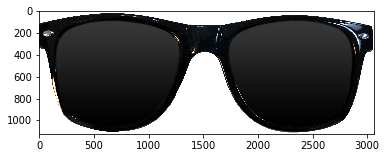

In [5]:
# load in sunglasses image with cv2 and IMREAD_UNCHANGED
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)

# plot our image
plt.imshow(sunglasses)

# print out its dimensions
print('Image shape: ', sunglasses.shape)

## The 4th dimension

You'll note that this image actually has *4 color channels*, not just 3 as your avg RGB image does. This is due to the flag we set `cv2.IMREAD_UNCHANGED`, which tells this to read in another color channel.

#### Alpha channel
It has the usual red, blue, and green channels any color image has, and the 4th channel respresents the **transparency level of each pixel** in the image; this is often called the **alpha** channel. Here's how the transparency channel works: the lower the value, the more transparent, or see-through, the pixel will become.  The lower bound (completely transparent) is zero here, so any pixels set to 0 will not be seen; these look like white background pixels in the image above, but they are actually totally transparent. 

This transparent channel allows us to place this rectangular image of sunglasses on an image of a face and still see the face area that is techically covered by the transparentbackground of the sunglasses image!

Let's check out the alpha channel of our sunglasses image in the next Python cell. Because many of the pixels in the background of the image have an alpha value of 0, we'll need to explicitly print out non-zero values if we want to see them.

The alpha channel looks like this (black pixels = transparent): 


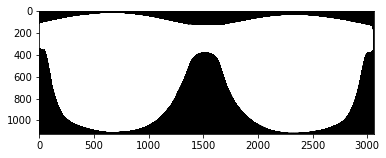

In [6]:
# print out the sunglasses transparency (alpha) channel
alpha_channel = sunglasses[:,:,3]
print ('The alpha channel looks like this (black pixels = transparent): ')
plt.imshow(alpha_channel, cmap='gray')

In [7]:
# just to double check that there are indeed non-zero values
# let's find and print out every value greater than zero
values = np.where(alpha_channel != 0)
print ('The non-zero values of the alpha channel are: ')
print (values)

The non-zero values of the alpha channel are: 
(array([  17,   17,   17, ..., 1109, 1109, 1109]), array([ 687,  688,  689, ..., 2376, 2377, 2378]))


#### Overlaying images

This means that when we place this sunglasses image on top of another image, we can use the transparency channel as a filter:

* If the pixels are non-transparent (alpha_channel > 0), overlay them on the new image

#### Keypoint locations

In doing this, it's helpful to understand which keypoint belongs to the eyes, mouth, etc., so in the image below we also print the index of each facial keypoint directly on the image so you can tell which keypoints are for the eyes, eyebrows, etc.,

<img src="images/landmarks_numbered.jpg" width=50% height=50%/>

It may be useful to use keypoints that correspond to the edges of the face to define the width of the sunglasses, and the locations of the eyes to define the placement.

Next, we'll load in an example image. Below, you've been given an image and set of keypoints from the provided training set of data, but you can use your own CNN model to generate keypoints for *any* image of a face (as in Notebook 3) and go through the same overlay process!

In [8]:
# load in the data if you have not already!
# otherwise, you may comment out this cell
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

--2019-10-08 14:38:46--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.120.178
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.120.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip’

train-test-data.zip 100%[===================>] 322.93M  98.0MB/s    in 3.5s    

2019-10-08 14:38:50 (93.2 MB/s) - ‘/data/train-test-data.zip’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip
   creating: /data/test/
  inflating: /data/test/Abdel_Aziz_Al-Hakim_00.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_01.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_10.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_11.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_40.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_41.jpg  
  inflating: /data/test/Abdullah_Gul_

  inflating: /data/test/Barbara_Walters_21.jpg  
  inflating: /data/test/Barbara_Walters_40.jpg  
  inflating: /data/test/Barbara_Walters_41.jpg  
  inflating: /data/test/Barbara_Walters_50.jpg  
  inflating: /data/test/Barbara_Walters_51.jpg  
  inflating: /data/test/Barry_Alvarez_00.jpg  
  inflating: /data/test/Barry_Alvarez_01.jpg  
  inflating: /data/test/Barry_Alvarez_10.jpg  
  inflating: /data/test/Barry_Alvarez_11.jpg  
  inflating: /data/test/Barry_Alvarez_20.jpg  
  inflating: /data/test/Barry_Alvarez_21.jpg  
  inflating: /data/test/Barry_Alvarez_30.jpg  
  inflating: /data/test/Barry_Alvarez_31.jpg  
  inflating: /data/test/Ben_Kingsley_10.jpg  
  inflating: /data/test/Ben_Kingsley_11.jpg  
  inflating: /data/test/Ben_Kingsley_20.jpg  
  inflating: /data/test/Ben_Kingsley_21.jpg  
  inflating: /data/test/Ben_Kingsley_50.jpg  
  inflating: /data/test/Ben_Kingsley_51.jpg  
  inflating: /data/test/Ben_Stein_10.jpg  
  inflating: /data/test/Ben_Stein_11.jpg  
  inflating: /dat

  inflating: /data/test/Chris_Noth_01.jpg  
  inflating: /data/test/Chris_Noth_10.jpg  
  inflating: /data/test/Chris_Noth_11.jpg  
  inflating: /data/test/Chris_Noth_30.jpg  
  inflating: /data/test/Chris_Noth_31.jpg  
  inflating: /data/test/Chris_Rock_00.jpg  
  inflating: /data/test/Chris_Rock_01.jpg  
  inflating: /data/test/Chris_Rock_10.jpg  
  inflating: /data/test/Chris_Rock_11.jpg  
  inflating: /data/test/Chris_Rock_20.jpg  
  inflating: /data/test/Chris_Rock_21.jpg  
  inflating: /data/test/Christine_Ebersole_00.jpg  
  inflating: /data/test/Christine_Ebersole_01.jpg  
  inflating: /data/test/Christine_Ebersole_20.jpg  
  inflating: /data/test/Christine_Ebersole_21.jpg  
  inflating: /data/test/Christine_Ebersole_50.jpg  
  inflating: /data/test/Christine_Ebersole_51.jpg  
  inflating: /data/test/Christopher_Amolsch_20.jpg  
  inflating: /data/test/Christopher_Amolsch_21.jpg  
  inflating: /data/test/Christopher_Amolsch_40.jpg  
  inflating: /data/test/Christopher_Amolsch_4

  inflating: /data/test/Eduardo_Duhalde_00.jpg  
  inflating: /data/test/Eduardo_Duhalde_01.jpg  
  inflating: /data/test/Eduardo_Duhalde_10.jpg  
  inflating: /data/test/Eduardo_Duhalde_11.jpg  
  inflating: /data/test/Eduardo_Duhalde_30.jpg  
  inflating: /data/test/Eduardo_Duhalde_31.jpg  
  inflating: /data/test/Edward_Burns_10.jpg  
  inflating: /data/test/Edward_Burns_11.jpg  
  inflating: /data/test/Edward_Burns_20.jpg  
  inflating: /data/test/Edward_Burns_21.jpg  
  inflating: /data/test/Edward_Burns_30.jpg  
  inflating: /data/test/Edward_Burns_31.jpg  
  inflating: /data/test/Edward_Burns_50.jpg  
  inflating: /data/test/Edward_Burns_51.jpg  
  inflating: /data/test/Edward_Norton_10.jpg  
  inflating: /data/test/Edward_Norton_11.jpg  
  inflating: /data/test/Edward_Norton_30.jpg  
  inflating: /data/test/Edward_Norton_31.jpg  
  inflating: /data/test/Edward_Norton_40.jpg  
  inflating: /data/test/Edward_Norton_41.jpg  
  inflating: /data/test/Edward_Norton_50.jpg  
  inflati

  inflating: /data/test/Frank_Keating_50.jpg  
  inflating: /data/test/Frank_Keating_51.jpg  
  inflating: /data/test/Frank_Solich_10.jpg  
  inflating: /data/test/Frank_Solich_11.jpg  
  inflating: /data/test/Frank_Solich_20.jpg  
  inflating: /data/test/Frank_Solich_21.jpg  
  inflating: /data/test/Frank_Solich_30.jpg  
  inflating: /data/test/Frank_Solich_31.jpg  
  inflating: /data/test/Franz_Fischler_00.jpg  
  inflating: /data/test/Franz_Fischler_01.jpg  
  inflating: /data/test/Franz_Fischler_30.jpg  
  inflating: /data/test/Franz_Fischler_31.jpg  
  inflating: /data/test/Franz_Fischler_40.jpg  
  inflating: /data/test/Franz_Fischler_41.jpg  
  inflating: /data/test/Franz_Fischler_50.jpg  
  inflating: /data/test/Franz_Fischler_51.jpg  
  inflating: /data/test/Gabi_Zimmer_00.jpg  
  inflating: /data/test/Gabi_Zimmer_01.jpg  
  inflating: /data/test/Gabi_Zimmer_10.jpg  
  inflating: /data/test/Gabi_Zimmer_11.jpg  
  inflating: /data/test/Gabi_Zimmer_20.jpg  
  inflating: /data/te

  inflating: /data/test/Janis_Ruth_Coulter_51.jpg  
  inflating: /data/test/JK_Rowling_20.jpg  
  inflating: /data/test/JK_Rowling_21.jpg  
  inflating: /data/test/JK_Rowling_30.jpg  
  inflating: /data/test/JK_Rowling_31.jpg  
  inflating: /data/test/JK_Rowling_40.jpg  
  inflating: /data/test/JK_Rowling_41.jpg  
  inflating: /data/test/JK_Rowling_50.jpg  
  inflating: /data/test/JK_Rowling_51.jpg  
  inflating: /data/test/Kate_Capshaw_10.jpg  
  inflating: /data/test/Kate_Capshaw_11.jpg  
  inflating: /data/test/Kate_Capshaw_20.jpg  
  inflating: /data/test/Kate_Capshaw_21.jpg  
  inflating: /data/test/Kate_Capshaw_40.jpg  
  inflating: /data/test/Kate_Capshaw_41.jpg  
  inflating: /data/test/Kate_Winslet_00.jpg  
  inflating: /data/test/Kate_Winslet_01.jpg  
  inflating: /data/test/Kate_Winslet_10.jpg  
  inflating: /data/test/Kate_Winslet_11.jpg  
  inflating: /data/test/Kate_Winslet_50.jpg  
  inflating: /data/test/Kate_Winslet_51.jpg  
  inflating: /data/test/Katharine_Hepburn_10

  inflating: /data/test/Linda_Dano_30.jpg  
  inflating: /data/test/Linda_Dano_31.jpg  
  inflating: /data/test/Linda_Dano_50.jpg  
  inflating: /data/test/Linda_Dano_51.jpg  
  inflating: /data/test/Linda_Franklin_00.jpg  
  inflating: /data/test/Linda_Franklin_01.jpg  
  inflating: /data/test/Linda_Franklin_10.jpg  
  inflating: /data/test/Linda_Franklin_11.jpg  
  inflating: /data/test/Linda_Franklin_20.jpg  
  inflating: /data/test/Linda_Franklin_21.jpg  
  inflating: /data/test/Linda_Franklin_40.jpg  
  inflating: /data/test/Linda_Franklin_41.jpg  
  inflating: /data/test/Linda_Sanchez_00.jpg  
  inflating: /data/test/Linda_Sanchez_01.jpg  
  inflating: /data/test/Linda_Sanchez_10.jpg  
  inflating: /data/test/Linda_Sanchez_11.jpg  
  inflating: /data/test/Linda_Sanchez_20.jpg  
  inflating: /data/test/Linda_Sanchez_21.jpg  
  inflating: /data/test/Linda_Sanchez_40.jpg  
  inflating: /data/test/Linda_Sanchez_41.jpg  
  inflating: /data/test/Lindsey_Graham_00.jpg  
  inflating: /da

  inflating: /data/test/Marissa_Jaret_Winokur_00.jpg  
  inflating: /data/test/Marissa_Jaret_Winokur_01.jpg  
  inflating: /data/test/Marissa_Jaret_Winokur_30.jpg  
  inflating: /data/test/Marissa_Jaret_Winokur_31.jpg  
  inflating: /data/test/Marissa_Jaret_Winokur_40.jpg  
  inflating: /data/test/Marissa_Jaret_Winokur_41.jpg  
  inflating: /data/test/Mark_Foley_10.jpg  
  inflating: /data/test/Mark_Foley_11.jpg  
  inflating: /data/test/Mark_Foley_40.jpg  
  inflating: /data/test/Mark_Foley_41.jpg  
  inflating: /data/test/Mark_Foley_50.jpg  
  inflating: /data/test/Mark_Foley_51.jpg  
  inflating: /data/test/Mark_Leno_10.jpg  
  inflating: /data/test/Mark_Leno_11.jpg  
  inflating: /data/test/Mark_Leno_20.jpg  
  inflating: /data/test/Mark_Leno_21.jpg  
  inflating: /data/test/Mark_Leno_30.jpg  
  inflating: /data/test/Mark_Leno_31.jpg  
  inflating: /data/test/Martin_Luther_King_III_00.jpg  
  inflating: /data/test/Martin_Luther_King_III_01.jpg  
  inflating: /data/test/Martin_Luthe

  inflating: /data/test/Pilar_Montenegro_20.jpg  
  inflating: /data/test/Pilar_Montenegro_21.jpg  
  inflating: /data/test/Pilar_Montenegro_50.jpg  
  inflating: /data/test/Pilar_Montenegro_51.jpg  
  inflating: /data/test/Piotr_Anderszewski_20.jpg  
  inflating: /data/test/Piotr_Anderszewski_21.jpg  
  inflating: /data/test/Piotr_Anderszewski_30.jpg  
  inflating: /data/test/Piotr_Anderszewski_31.jpg  
  inflating: /data/test/Piotr_Anderszewski_50.jpg  
  inflating: /data/test/Piotr_Anderszewski_51.jpg  
  inflating: /data/test/Poala_Suarez_30.jpg  
  inflating: /data/test/Poala_Suarez_31.jpg  
  inflating: /data/test/Poala_Suarez_40.jpg  
  inflating: /data/test/Poala_Suarez_41.jpg  
  inflating: /data/test/Poala_Suarez_50.jpg  
  inflating: /data/test/Poala_Suarez_51.jpg  
  inflating: /data/test/Prince_Harry_10.jpg  
  inflating: /data/test/Prince_Harry_11.jpg  
  inflating: /data/test/Prince_Harry_20.jpg  
  inflating: /data/test/Prince_Harry_21.jpg  
  inflating: /data/test/Prin

  inflating: /data/test/Ted_Turner_51.jpg  
  inflating: /data/test/Teresa_Heinz_Kerry_00.jpg  
  inflating: /data/test/Teresa_Heinz_Kerry_01.jpg  
  inflating: /data/test/Teresa_Heinz_Kerry_10.jpg  
  inflating: /data/test/Teresa_Heinz_Kerry_11.jpg  
  inflating: /data/test/Teresa_Heinz_Kerry_20.jpg  
  inflating: /data/test/Teresa_Heinz_Kerry_21.jpg  
  inflating: /data/test/Terje_Roed-Larsen_00.jpg  
  inflating: /data/test/Terje_Roed-Larsen_01.jpg  
  inflating: /data/test/Terje_Roed-Larsen_20.jpg  
  inflating: /data/test/Terje_Roed-Larsen_21.jpg  
  inflating: /data/test/Terje_Roed-Larsen_30.jpg  
  inflating: /data/test/Terje_Roed-Larsen_31.jpg  
  inflating: /data/test/Tessa_Jowell_00.jpg  
  inflating: /data/test/Tessa_Jowell_01.jpg  
  inflating: /data/test/Tessa_Jowell_20.jpg  
  inflating: /data/test/Tessa_Jowell_21.jpg  
  inflating: /data/test/Tessa_Jowell_30.jpg  
  inflating: /data/test/Tessa_Jowell_31.jpg  
  inflating: /data/test/Tessa_Jowell_50.jpg  
  inflating: /da

  inflating: /data/training/Abdel_Aziz_Al-Hakim_00.jpg  
  inflating: /data/training/Abdel_Aziz_Al-Hakim_01.jpg  
  inflating: /data/training/Abdel_Aziz_Al-Hakim_02.jpg  
  inflating: /data/training/Abdel_Aziz_Al-Hakim_10.jpg  
  inflating: /data/training/Abdel_Aziz_Al-Hakim_11.jpg  
  inflating: /data/training/Abdel_Aziz_Al-Hakim_12.jpg  
  inflating: /data/training/Abdel_Aziz_Al-Hakim_40.jpg  
  inflating: /data/training/Abdel_Aziz_Al-Hakim_41.jpg  
  inflating: /data/training/Abdel_Aziz_Al-Hakim_42.jpg  
  inflating: /data/training/Abdullah_Gul_10.jpg  
  inflating: /data/training/Abdullah_Gul_11.jpg  
  inflating: /data/training/Abdullah_Gul_12.jpg  
  inflating: /data/training/Abdullah_Gul_30.jpg  
  inflating: /data/training/Abdullah_Gul_31.jpg  
  inflating: /data/training/Abdullah_Gul_32.jpg  
  inflating: /data/training/Abdullah_Gul_50.jpg  
  inflating: /data/training/Abdullah_Gul_51.jpg  
  inflating: /data/training/Abdullah_Gul_52.jpg  
  inflating: /data/training/Adam_Sand

  inflating: /data/training/Amelia_Vega_32.jpg  
  inflating: /data/training/Amelia_Vega_40.jpg  
  inflating: /data/training/Amelia_Vega_41.jpg  
  inflating: /data/training/Amelia_Vega_42.jpg  
  inflating: /data/training/Amy_Brenneman_10.jpg  
  inflating: /data/training/Amy_Brenneman_11.jpg  
  inflating: /data/training/Amy_Brenneman_12.jpg  
  inflating: /data/training/Amy_Brenneman_30.jpg  
  inflating: /data/training/Amy_Brenneman_31.jpg  
  inflating: /data/training/Amy_Brenneman_32.jpg  
  inflating: /data/training/Amy_Brenneman_50.jpg  
  inflating: /data/training/Amy_Brenneman_51.jpg  
  inflating: /data/training/Amy_Brenneman_52.jpg  
  inflating: /data/training/Andrea_Bocelli_10.jpg  
  inflating: /data/training/Andrea_Bocelli_11.jpg  
  inflating: /data/training/Andrea_Bocelli_12.jpg  
  inflating: /data/training/Andrea_Bocelli_20.jpg  
  inflating: /data/training/Andrea_Bocelli_21.jpg  
  inflating: /data/training/Andrea_Bocelli_22.jpg  
  inflating: /data/training/Andre

  inflating: /data/training/Cameron_Diaz_22.jpg  
  inflating: /data/training/Cameron_Diaz_40.jpg  
  inflating: /data/training/Cameron_Diaz_41.jpg  
  inflating: /data/training/Cameron_Diaz_42.jpg  
  inflating: /data/training/Cameron_Diaz_50.jpg  
  inflating: /data/training/Cameron_Diaz_51.jpg  
  inflating: /data/training/Cameron_Diaz_52.jpg  
  inflating: /data/training/Carey_Lowell_00.jpg  
  inflating: /data/training/Carey_Lowell_01.jpg  
  inflating: /data/training/Carey_Lowell_02.jpg  
  inflating: /data/training/Carey_Lowell_20.jpg  
  inflating: /data/training/Carey_Lowell_21.jpg  
  inflating: /data/training/Carey_Lowell_22.jpg  
  inflating: /data/training/Carey_Lowell_30.jpg  
  inflating: /data/training/Carey_Lowell_31.jpg  
  inflating: /data/training/Carey_Lowell_32.jpg  
  inflating: /data/training/Carla_Gugino_10.jpg  
  inflating: /data/training/Carla_Gugino_11.jpg  
  inflating: /data/training/Carla_Gugino_12.jpg  
  inflating: /data/training/Carla_Gugino_30.jpg  


  inflating: /data/training/Charlize_Theron_51.jpg  
  inflating: /data/training/Charlize_Theron_52.jpg  
  inflating: /data/training/Charlotte_Casiraghi_00.jpg  
  inflating: /data/training/Charlotte_Casiraghi_01.jpg  
  inflating: /data/training/Charlotte_Casiraghi_02.jpg  
  inflating: /data/training/Charlotte_Casiraghi_10.jpg  
  inflating: /data/training/Charlotte_Casiraghi_11.jpg  
  inflating: /data/training/Charlotte_Casiraghi_12.jpg  
  inflating: /data/training/Charlotte_Casiraghi_20.jpg  
  inflating: /data/training/Charlotte_Casiraghi_21.jpg  
  inflating: /data/training/Charlotte_Casiraghi_22.jpg  
  inflating: /data/training/Charlotte_Rampling_00.jpg  
  inflating: /data/training/Charlotte_Rampling_01.jpg  
  inflating: /data/training/Charlotte_Rampling_02.jpg  
  inflating: /data/training/Charlotte_Rampling_30.jpg  
  inflating: /data/training/Charlotte_Rampling_31.jpg  
  inflating: /data/training/Charlotte_Rampling_32.jpg  
  inflating: /data/training/Charlotte_Ramplin

  inflating: /data/training/Cindy_Klassen_00.jpg  
  inflating: /data/training/Cindy_Klassen_01.jpg  
  inflating: /data/training/Cindy_Klassen_02.jpg  
  inflating: /data/training/Cindy_Klassen_30.jpg  
  inflating: /data/training/Cindy_Klassen_31.jpg  
  inflating: /data/training/Cindy_Klassen_32.jpg  
  inflating: /data/training/Cindy_Klassen_40.jpg  
  inflating: /data/training/Cindy_Klassen_41.jpg  
  inflating: /data/training/Cindy_Klassen_42.jpg  
  inflating: /data/training/Claire_Danes_30.jpg  
  inflating: /data/training/Claire_Danes_31.jpg  
  inflating: /data/training/Claire_Danes_32.jpg  
  inflating: /data/training/Claire_Danes_40.jpg  
  inflating: /data/training/Claire_Danes_41.jpg  
  inflating: /data/training/Claire_Danes_42.jpg  
  inflating: /data/training/Claire_Danes_50.jpg  
  inflating: /data/training/Claire_Danes_51.jpg  
  inflating: /data/training/Claire_Danes_52.jpg  
  inflating: /data/training/Clark_Randt_10.jpg  
  inflating: /data/training/Clark_Randt_11

  inflating: /data/training/David_Brent_32.jpg  
  inflating: /data/training/David_Caruso_00.jpg  
  inflating: /data/training/David_Caruso_01.jpg  
  inflating: /data/training/David_Caruso_02.jpg  
  inflating: /data/training/David_Caruso_10.jpg  
  inflating: /data/training/David_Caruso_11.jpg  
  inflating: /data/training/David_Caruso_12.jpg  
  inflating: /data/training/David_Caruso_30.jpg  
  inflating: /data/training/David_Caruso_31.jpg  
  inflating: /data/training/David_Caruso_32.jpg  
  inflating: /data/training/David_Caruso_40.jpg  
  inflating: /data/training/David_Caruso_41.jpg  
  inflating: /data/training/David_Caruso_42.jpg  
  inflating: /data/training/Ed_Rendell_00.jpg  
  inflating: /data/training/Ed_Rendell_01.jpg  
  inflating: /data/training/Ed_Rendell_02.jpg  
  inflating: /data/training/Ed_Rendell_20.jpg  
  inflating: /data/training/Ed_Rendell_21.jpg  
  inflating: /data/training/Ed_Rendell_22.jpg  
  inflating: /data/training/Ed_Rendell_50.jpg  
  inflating: /d

  inflating: /data/training/Emma_Thompson_52.jpg  
  inflating: /data/training/Emmy_Rossum_20.jpg  
  inflating: /data/training/Emmy_Rossum_21.jpg  
  inflating: /data/training/Emmy_Rossum_22.jpg  
  inflating: /data/training/Emmy_Rossum_30.jpg  
  inflating: /data/training/Emmy_Rossum_31.jpg  
  inflating: /data/training/Emmy_Rossum_32.jpg  
  inflating: /data/training/Emmy_Rossum_40.jpg  
  inflating: /data/training/Emmy_Rossum_41.jpg  
  inflating: /data/training/Emmy_Rossum_42.jpg  
  inflating: /data/training/Emmy_Rossum_50.jpg  
  inflating: /data/training/Emmy_Rossum_51.jpg  
  inflating: /data/training/Emmy_Rossum_52.jpg  
  inflating: /data/training/Eric_Benet_00.jpg  
  inflating: /data/training/Eric_Benet_01.jpg  
  inflating: /data/training/Eric_Benet_02.jpg  
  inflating: /data/training/Eric_Benet_10.jpg  
  inflating: /data/training/Eric_Benet_11.jpg  
  inflating: /data/training/Eric_Benet_12.jpg  
  inflating: /data/training/Eric_Benet_30.jpg  
  inflating: /data/traini

  inflating: /data/training/Gabi_Zimmer_22.jpg  
  inflating: /data/training/Gabi_Zimmer_50.jpg  
  inflating: /data/training/Gabi_Zimmer_51.jpg  
  inflating: /data/training/Gabi_Zimmer_52.jpg  
  inflating: /data/training/Gary_Bettman_10.jpg  
  inflating: /data/training/Gary_Bettman_11.jpg  
  inflating: /data/training/Gary_Bettman_12.jpg  
  inflating: /data/training/Gary_Bettman_30.jpg  
  inflating: /data/training/Gary_Bettman_31.jpg  
  inflating: /data/training/Gary_Bettman_32.jpg  
  inflating: /data/training/Gary_Bettman_40.jpg  
  inflating: /data/training/Gary_Bettman_41.jpg  
  inflating: /data/training/Gary_Bettman_42.jpg  
  inflating: /data/training/Gary_Coleman_30.jpg  
  inflating: /data/training/Gary_Coleman_31.jpg  
  inflating: /data/training/Gary_Coleman_32.jpg  
  inflating: /data/training/Gary_Coleman_40.jpg  
  inflating: /data/training/Gary_Coleman_41.jpg  
  inflating: /data/training/Gary_Coleman_42.jpg  
  inflating: /data/training/Gary_Coleman_50.jpg  
  in

  inflating: /data/training/James_Cunningham_32.jpg  
  inflating: /data/training/James_Cunningham_40.jpg  
  inflating: /data/training/James_Cunningham_41.jpg  
  inflating: /data/training/James_Cunningham_42.jpg  
  inflating: /data/training/James_Hoffa_10.jpg  
  inflating: /data/training/James_Hoffa_11.jpg  
  inflating: /data/training/James_Hoffa_12.jpg  
  inflating: /data/training/James_Hoffa_20.jpg  
  inflating: /data/training/James_Hoffa_21.jpg  
  inflating: /data/training/James_Hoffa_22.jpg  
  inflating: /data/training/James_Hoffa_40.jpg  
  inflating: /data/training/James_Hoffa_41.jpg  
  inflating: /data/training/James_Hoffa_42.jpg  
  inflating: /data/training/James_Hoffa_50.jpg  
  inflating: /data/training/James_Hoffa_51.jpg  
  inflating: /data/training/James_Hoffa_52.jpg  
  inflating: /data/training/James_Lockhart_00.jpg  
  inflating: /data/training/James_Lockhart_01.jpg  
  inflating: /data/training/James_Lockhart_02.jpg  
  inflating: /data/training/James_Lockha

  inflating: /data/training/Keith_Olbermann_00.jpg  
  inflating: /data/training/Keith_Olbermann_01.jpg  
  inflating: /data/training/Keith_Olbermann_02.jpg  
  inflating: /data/training/Keith_Olbermann_10.jpg  
  inflating: /data/training/Keith_Olbermann_11.jpg  
  inflating: /data/training/Keith_Olbermann_12.jpg  
  inflating: /data/training/Keith_Olbermann_20.jpg  
  inflating: /data/training/Keith_Olbermann_21.jpg  
  inflating: /data/training/Keith_Olbermann_22.jpg  
  inflating: /data/training/Keith_Olbermann_50.jpg  
  inflating: /data/training/Keith_Olbermann_51.jpg  
  inflating: /data/training/Keith_Olbermann_52.jpg  
  inflating: /data/training/Keith_Tyson_00.jpg  
  inflating: /data/training/Keith_Tyson_01.jpg  
  inflating: /data/training/Keith_Tyson_02.jpg  
  inflating: /data/training/Keith_Tyson_10.jpg  
  inflating: /data/training/Keith_Tyson_11.jpg  
  inflating: /data/training/Keith_Tyson_12.jpg  
  inflating: /data/training/Keith_Tyson_20.jpg  
  inflating: /data/tr

  inflating: /data/training/Lene_Espersen_21.jpg  
  inflating: /data/training/Lene_Espersen_22.jpg  
  inflating: /data/training/Lene_Espersen_40.jpg  
  inflating: /data/training/Lene_Espersen_41.jpg  
  inflating: /data/training/Lene_Espersen_42.jpg  
  inflating: /data/training/Lesia_Burlak_00.jpg  
  inflating: /data/training/Lesia_Burlak_01.jpg  
  inflating: /data/training/Lesia_Burlak_02.jpg  
  inflating: /data/training/Lesia_Burlak_20.jpg  
  inflating: /data/training/Lesia_Burlak_21.jpg  
  inflating: /data/training/Lesia_Burlak_22.jpg  
  inflating: /data/training/Lesia_Burlak_30.jpg  
  inflating: /data/training/Lesia_Burlak_31.jpg  
  inflating: /data/training/Lesia_Burlak_32.jpg  
  inflating: /data/training/Lester_Holt_00.jpg  
  inflating: /data/training/Lester_Holt_01.jpg  
  inflating: /data/training/Lester_Holt_02.jpg  
  inflating: /data/training/Lester_Holt_30.jpg  
  inflating: /data/training/Lester_Holt_31.jpg  
  inflating: /data/training/Lester_Holt_32.jpg  
 

  inflating: /data/training/Lucio_Stanca_41.jpg  
  inflating: /data/training/Lucio_Stanca_42.jpg  
  inflating: /data/training/Luis_Ernesto_Derbez_Bautista_00.jpg  
  inflating: /data/training/Luis_Ernesto_Derbez_Bautista_01.jpg  
  inflating: /data/training/Luis_Ernesto_Derbez_Bautista_02.jpg  
  inflating: /data/training/Luis_Ernesto_Derbez_Bautista_10.jpg  
  inflating: /data/training/Luis_Ernesto_Derbez_Bautista_11.jpg  
  inflating: /data/training/Luis_Ernesto_Derbez_Bautista_12.jpg  
  inflating: /data/training/Luis_Ernesto_Derbez_Bautista_50.jpg  
  inflating: /data/training/Luis_Ernesto_Derbez_Bautista_51.jpg  
  inflating: /data/training/Luis_Ernesto_Derbez_Bautista_52.jpg  
  inflating: /data/training/Luis_Fonsi_20.jpg  
  inflating: /data/training/Luis_Fonsi_21.jpg  
  inflating: /data/training/Luis_Fonsi_22.jpg  
  inflating: /data/training/Luis_Fonsi_40.jpg  
  inflating: /data/training/Luis_Fonsi_41.jpg  
  inflating: /data/training/Luis_Fonsi_42.jpg  
  inflating: /data

  inflating: /data/training/Martin_Sheen_02.jpg  
  inflating: /data/training/Martin_Sheen_30.jpg  
  inflating: /data/training/Martin_Sheen_31.jpg  
  inflating: /data/training/Martin_Sheen_32.jpg  
  inflating: /data/training/Martin_Sheen_40.jpg  
  inflating: /data/training/Martin_Sheen_41.jpg  
  inflating: /data/training/Martin_Sheen_42.jpg  
  inflating: /data/training/Martin_Sheen_50.jpg  
  inflating: /data/training/Martin_Sheen_51.jpg  
  inflating: /data/training/Martin_Sheen_52.jpg  
  inflating: /data/training/Mary_Landrieu_00.jpg  
  inflating: /data/training/Mary_Landrieu_01.jpg  
  inflating: /data/training/Mary_Landrieu_02.jpg  
  inflating: /data/training/Mary_Landrieu_20.jpg  
  inflating: /data/training/Mary_Landrieu_21.jpg  
  inflating: /data/training/Mary_Landrieu_22.jpg  
  inflating: /data/training/Mary_Landrieu_30.jpg  
  inflating: /data/training/Mary_Landrieu_31.jpg  
  inflating: /data/training/Mary_Landrieu_32.jpg  
  inflating: /data/training/Mary_Robinson

  inflating: /data/training/Pat_Riley_52.jpg  
  inflating: /data/training/Patrick_Leahy_10.jpg  
  inflating: /data/training/Patrick_Leahy_11.jpg  
  inflating: /data/training/Patrick_Leahy_12.jpg  
  inflating: /data/training/Patrick_Leahy_20.jpg  
  inflating: /data/training/Patrick_Leahy_21.jpg  
  inflating: /data/training/Patrick_Leahy_22.jpg  
  inflating: /data/training/Patrick_Leahy_30.jpg  
  inflating: /data/training/Patrick_Leahy_31.jpg  
  inflating: /data/training/Patrick_Leahy_32.jpg  
  inflating: /data/training/Paul_Otellini_00.jpg  
  inflating: /data/training/Paul_Otellini_01.jpg  
  inflating: /data/training/Paul_Otellini_02.jpg  
  inflating: /data/training/Paul_Otellini_10.jpg  
  inflating: /data/training/Paul_Otellini_11.jpg  
  inflating: /data/training/Paul_Otellini_12.jpg  
  inflating: /data/training/Paul_Otellini_20.jpg  
  inflating: /data/training/Paul_Otellini_21.jpg  
  inflating: /data/training/Paul_Otellini_22.jpg  
  inflating: /data/training/Paul_Re

  inflating: /data/training/Queen_Noor_30.jpg  
  inflating: /data/training/Queen_Noor_31.jpg  
  inflating: /data/training/Queen_Noor_32.jpg  
  inflating: /data/training/Queen_Noor_50.jpg  
  inflating: /data/training/Queen_Noor_51.jpg  
  inflating: /data/training/Queen_Noor_52.jpg  
  inflating: /data/training/Queen_Rania_10.jpg  
  inflating: /data/training/Queen_Rania_11.jpg  
  inflating: /data/training/Queen_Rania_12.jpg  
  inflating: /data/training/Queen_Rania_30.jpg  
  inflating: /data/training/Queen_Rania_31.jpg  
  inflating: /data/training/Queen_Rania_32.jpg  
  inflating: /data/training/Queen_Rania_50.jpg  
  inflating: /data/training/Queen_Rania_51.jpg  
  inflating: /data/training/Queen_Rania_52.jpg  
  inflating: /data/training/Rachel_Hunter_30.jpg  
  inflating: /data/training/Rachel_Hunter_31.jpg  
  inflating: /data/training/Rachel_Hunter_32.jpg  
  inflating: /data/training/Rachel_Hunter_40.jpg  
  inflating: /data/training/Rachel_Hunter_41.jpg  
  inflating: /da

  inflating: /data/training/Timothy_Goebel_00.jpg  
  inflating: /data/training/Timothy_Goebel_01.jpg  
  inflating: /data/training/Timothy_Goebel_02.jpg  
  inflating: /data/training/Timothy_Goebel_30.jpg  
  inflating: /data/training/Timothy_Goebel_31.jpg  
  inflating: /data/training/Timothy_Goebel_32.jpg  
  inflating: /data/training/Timothy_Goebel_40.jpg  
  inflating: /data/training/Timothy_Goebel_41.jpg  
  inflating: /data/training/Timothy_Goebel_42.jpg  
  inflating: /data/training/Timothy_Goebel_50.jpg  
  inflating: /data/training/Timothy_Goebel_51.jpg  
  inflating: /data/training/Timothy_Goebel_52.jpg  
  inflating: /data/training/Tina_Brown_20.jpg  
  inflating: /data/training/Tina_Brown_21.jpg  
  inflating: /data/training/Tina_Brown_22.jpg  
  inflating: /data/training/Tina_Brown_40.jpg  
  inflating: /data/training/Tina_Brown_41.jpg  
  inflating: /data/training/Tina_Brown_42.jpg  
  inflating: /data/training/Tina_Brown_50.jpg  
  inflating: /data/training/Tina_Brown_5

  inflating: /data/training/William_McDonough_32.jpg  
  inflating: /data/training/William_McDonough_40.jpg  
  inflating: /data/training/William_McDonough_41.jpg  
  inflating: /data/training/William_McDonough_42.jpg  
  inflating: /data/training/Yang_Jianli_00.jpg  
  inflating: /data/training/Yang_Jianli_01.jpg  
  inflating: /data/training/Yang_Jianli_02.jpg  
  inflating: /data/training/Yang_Jianli_10.jpg  
  inflating: /data/training/Yang_Jianli_11.jpg  
  inflating: /data/training/Yang_Jianli_12.jpg  
  inflating: /data/training/Yang_Jianli_30.jpg  
  inflating: /data/training/Yang_Jianli_31.jpg  
  inflating: /data/training/Yang_Jianli_32.jpg  
  inflating: /data/training/Yuri_Fedotov_20.jpg  
  inflating: /data/training/Yuri_Fedotov_21.jpg  
  inflating: /data/training/Yuri_Fedotov_22.jpg  
  inflating: /data/training/Yuri_Fedotov_30.jpg  
  inflating: /data/training/Yuri_Fedotov_31.jpg  
  inflating: /data/training/Yuri_Fedotov_32.jpg  
  inflating: /data/training/Yuri_Fedoto

In [9]:
# load in training data
key_pts_frame = pd.read_csv('/data/training_frames_keypoints.csv')

# print out some stats about the data
print('Number of images: ', key_pts_frame.shape[0])

Number of images:  3462


In [10]:
# helper function to display keypoints
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


Image name:  Kemal_Dervis_12.jpg


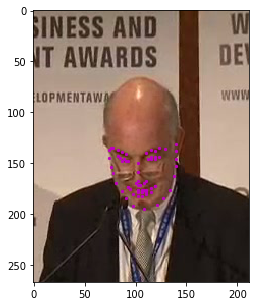

In [73]:
# a selected image
n = 115
image_name = key_pts_frame.iloc[n, 0]
image = mpimg.imread(os.path.join('/data/training/', image_name))
key_pts = key_pts_frame.iloc[n, 1:].as_matrix()
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)

plt.figure(figsize=(5, 5))
show_keypoints(image, key_pts)
plt.show()

Next, you'll see an example of placing sunglasses on the person in the loaded image.

Note that the keypoints are numbered off-by-one in the numbered image above, and so `key_pts[0,:]` corresponds to the first point (1) in the labelled image.

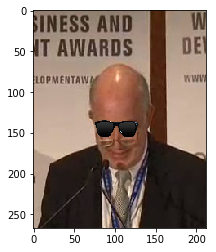

In [74]:
# Display sunglasses on top of the image in the appropriate place

# copy of the face image for overlay
image_copy = np.copy(image)

# top-left location for sunglasses to go
# 17 = edge of left eyebrow
x = int(key_pts[17, 0])
y = int(key_pts[17, 1])

# height and width of sunglasses
# h = length of nose
h = int(abs(key_pts[27,1] - key_pts[33,1]))
# w = left to right eyebrow edges
w = int(abs(key_pts[17,0] - key_pts[26,0]))

# read in sunglasses
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)
# resize sunglasses
new_sunglasses =  cv2.resize(sunglasses, (w, h), interpolation = cv2.INTER_CUBIC)

# get region of interest on the face to change
roi_color = image_copy[y:y+h,x:x+w]

# find all non-transparent pts
ind = np.argwhere(new_sunglasses[:,:,3] > 0)

# for each non-transparent point, replace the original image pixel with that of the new_sunglasses
for i in range(3):
    roi_color[ind[:,0],ind[:,1],i] = new_sunglasses[ind[:,0],ind[:,1],i]    
# set the area of the image to the changed region with sunglasses
image_copy[y:y+h,x:x+w] = roi_color


# display the result!
plt.imshow(image_copy)

#### Further steps

Look in the `images/` directory to see other available .png's for overlay! Also, you may notice that the overlay of the sunglasses is not entirely perfect; you're encouraged to play around with the scale of the width and height of the glasses and investigate how to perform [image rotation](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html) in OpenCV so as to match an overlay with any facial pose.

First define a function that rotates an image the desired amount, and modifies the window to make it fit. This can be obtained with some algebra.

In [75]:
# Function taken from https://stackoverflow.com/questions/11764575/python-2-7-3-opencv-2-4-after-rotation-window-doesnt-fit-image
def rotateAndScale(img, scaleFactor = 0.5, degreesCCW = 30):
    (oldY,oldX) = img.shape[0:2] #note: numpy uses (y,x) convention but most OpenCV functions use (x,y)
    M = cv2.getRotationMatrix2D(center=(oldX/2,oldY/2), angle=degreesCCW, scale=scaleFactor) #rotate about center of image.

    #choose a new image size.
    newX,newY = oldX*scaleFactor,oldY*scaleFactor
    #include this if you want to prevent corners being cut off
    r = np.deg2rad(degreesCCW)
    newX,newY = (abs(np.sin(r)*newY) + abs(np.cos(r)*newX),abs(np.sin(r)*newX) + abs(np.cos(r)*newY))

    #the warpAffine function call, below, basically works like this:
    # 1. apply the M transformation on each pixel of the original image
    # 2. save everything that falls within the upper-left "dsize" portion of the resulting image.

    #So I will find the translation that moves the result to the center of that region.
    (tx,ty) = ((newX-oldX)/2,(newY-oldY)/2)
    M[0,2] += tx #third column of matrix holds translation, which takes effect after rotation.
    M[1,2] += ty

    rotatedImg = cv2.warpAffine(img, M, dsize=(int(newX),int(newY)))
    return rotatedImg

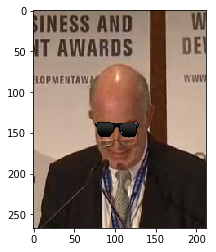

In [76]:
# Display sunglasses on top of the image in the appropriate place

# copy of the face image for overlay
image_copy = np.copy(image)

# Get coordinates of left and right eyebrows to measure distance and inclination
left_eyebrow = key_pts[17]
right_eyebrow = key_pts[26]

dist = right_eyebrow - left_eyebrow

# Get the angle using arctan. Then transform it into degrees
angle_rad = np.arctan(dist[1]/dist[0])
angle_deg = np.rad2deg(angle_rad)


# top-left location for sunglasses to go
# 17 = edge of left eyebrow
x = int(key_pts[17, 0])
y = int(key_pts[17, 1] + dist[1])

# height and width of sunglasses
# h = length of nose
dist_h = int(np.ceil(np.linalg.norm(key_pts[27] - key_pts[33])))
# w = left to right eyebrow edges
dist_w = int(np.ceil(np.linalg.norm(key_pts[17] - key_pts[26])))

h = int(np.ceil(dist_h*np.cos(-angle_rad) + dist_w*np.sin(-angle_rad)))
w = int(np.ceil(dist_h*np.sin(-angle_rad) + dist_w*np.cos(-angle_rad)))

# read in sunglasses
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)

# Rotate sunglasses
sunglasses = rotateAndScale(sunglasses_copy,degreesCCW=-angle_deg)

# resize sunglasses
new_sunglasses =  cv2.resize(sunglasses, (w, h), interpolation = cv2.INTER_CUBIC)

# get region of interest on the face to change
roi_color = image_copy[y:y+h,x:x+w]

# find all non-transparent pts
ind = np.argwhere(new_sunglasses[:,:,3] > 0)

# for each non-transparent point, replace the original image pixel with that of the new_sunglasses
for i in range(3):
    roi_color[ind[:,0],ind[:,1],i] = new_sunglasses[ind[:,0],ind[:,1],i]    
# set the area of the image to the changed region with sunglasses
image_copy[y:y+h,x:x+w] = roi_color


# display the result!
plt.imshow(image_copy)